<a href="https://colab.research.google.com/github/cdmurray80/object_detection/blob/main/factors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

In [77]:

#
# Helper functions
#
# Given covariance, compute correlation
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    return correlation

#Given covariance and loadings, compute variance.
#If loadings represent differences from target, this will return tracking variance
def compute_variance(cov, loadings):
  return(np.matmul(loadings.transpose(),np.matmul(cov, loadings))[0,0])


In [78]:
#
# CHANGE THIS AS YOU SEE FIT
#
# Create our covariance matrix
cov_diag_term = .6
cov = np.matrix([[5.0,cov_diag_term],[cov_diag_term,0.3]]);

#
# Sanity check, and show 
assert(cov_diag_term < (cov[0,0]*cov[1,1])**0.5)
cor = correlation_from_covariance(cov)
print('Covariance:\n', cov, '\nCorrelation:\n', cor)

Covariance:
 [[5.  0.6]
 [0.6 0.3]] 
Correlation:
 [[1.         0.48989795]
 [0.48989795 1.        ]]


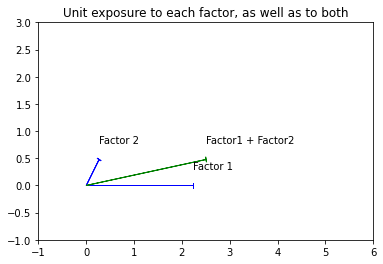

In [79]:
def arrow_w_title(plt_ax, x, y, title, edg_color='b'):
  plt_ax.arrow(0,0,x,y, head_length = 0.0, head_width=0.1, edgecolor=edg_color)
  plt_ax.annotate(title, xy=(x,y+0.3))

#
# Plot vectors to show risk of unit exposure to either factor
ax = plt.axes()
unit_var = compute_variance(cov, np.matrix([[1.],[1.]]))
arrow_w_title(ax, cov[0,0]**0.5,0, 'Factor 1')

# This is a bit subtle...we use the covariance to scale our plot so that the
# length of a vector with unit exposure to each factor is the risk of 
# unit exposure that each factor.
#factor_2_dx = (unit_var - cov[1,1])**0.5 - cov[0,0]**0.5
factor_2_dx = (unit_var - cov[0,0] - cov[1,1])/(2*(cov[0,0]**0.5))
factor_2_dy = (cov[1,1] - factor_2_dx**2)**0.5
arrow_w_title(ax, factor_2_dx,factor_2_dy, 'Factor 2')
arrow_w_title(ax, cov[0,0]**0.5 + factor_2_dx,factor_2_dy, 'Factor1 + Factor2', edg_color='g')
ax.set_xlim(-1,6)
ax.set_ylim(-1,3)
plt.title('Unit exposure to each factor, as well as to both')
plt.show()

In [80]:
print('Port 1 has 1 unit of factor 1 and risk:',compute_variance(cov, np.matrix([[1.],[0.]]))**0.5)
print('Port 2 has ~4 units of factor 2 and risk:',compute_variance(cov, np.matrix([[0.],[4.08]]))**0.5)
print('Port 3 has 1 unit of factor 2 and risk:',compute_variance(cov, np.matrix([[0.],[1]]))**0.5)
print('Covariance\n',cov, '\nCovariance sqroooted\n', np.sqrt(cov))

Port 1 has 1 unit of factor 1 and risk: 2.23606797749979
Port 2 has ~4 units of factor 2 and risk: 2.234708034621078
Port 3 has 1 unit of factor 2 and risk: 0.5477225575051661
Covariance
 [[5.  0.6]
 [0.6 0.3]] 
Covariance sqroooted
 [[2.23606798 0.77459667]
 [0.77459667 0.54772256]]


In [81]:
# Sanity check that the risk of unit exposure to each factor equals the plotted L2 norm
print('Risk: {:.5f}, L2 Norm: {:.5f}'.format( unit_var ** 0.5, ((cov[0,0]**0.5 + factor_2_dx)**2 + factor_2_dy**2)** 0.5))

Risk: 2.54951, L2 Norm: 2.54951


Eigenvalue  0 :
Value: 5.075386567126981 
Vector:
 [[0.992199  ]
 [0.12466413]] 


Eigenvalue  1 :
Value: 0.22461343287301933 
Vector:
 [[-0.12466413]
 [ 0.992199  ]] 




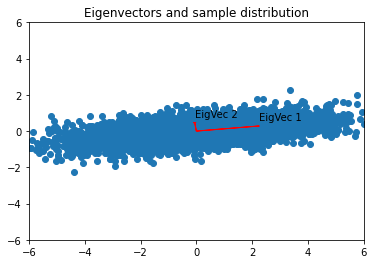

In [82]:
#Do eigen decomposition...annoying but we need extra code to sort eigenvectors so it's more than 1 line
# Probably 95% of users want the result sorted...idk why it's not an argument to return in sorted order
eigenvalues, eigenvectors = np.linalg.eig(cov)
idx = (eigenvalues).argsort()[::-1]   
eigenvectors = eigenvectors[:,idx]
eigenvalues = eigenvalues[idx]

# Plot samples and eigenvectors
samples=np.random.multivariate_normal(np.array([0,0]),cov, size=4000)
ax=plt.axes()
plt.scatter(samples[:,0],samples[:,1])
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
for i in range(2):
  arrow_w_title(ax, eigenvectors[0,i]*eigenvalues[i]**0.5,eigenvectors[1,i]*eigenvalues[i]**0.5, 'EigVec ' + str(i+1), edg_color='r')
  print( 'Eigenvalue ', i, ':\nValue:', eigenvalues[i], '\nVector:\n', eigenvectors[:,i],'\n\n')
plt.title('Eigenvectors and sample distribution')
plt.show()

In [86]:
# Now the orthogonal factors are simply the eigenvectors times the raw factors...here I make up 'raw' factor loadings and compute 'orthogonalized' loadings
# Annoyingly you have to transpose the eigenvector matrix

#
# CHANGE NUMBERS HERE IF YOU WANT
raw_factor_loadings = np.array([1.,0.0])

# Here the orthogonalized factors are constructed to have unit variance, so the exposure is much larger in the first factors because it captures most variance
orth_factor_loadings = np.multiply(np.sqrt(eigenvalues),np.matmul(eigenvectors.transpose(), raw_factor_loadings))
print('Factor transformation: ', raw_factor_loadings, '-->', orth_factor_loadings)


Factor transformation:  [1. 0.] --> [[ 2.23528729 -0.05908257]]


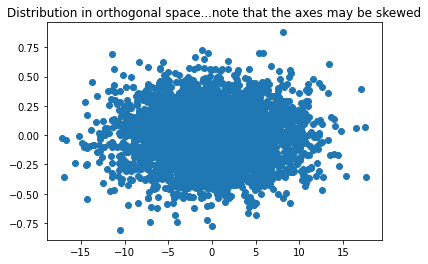

In [84]:
orth_samples = np.matmul(eigenvectors.transpose(), samples.transpose()).transpose() #Alt could do samples * eigenvectors
orth_samples = np.multiply(orth_samples, np.sqrt(eigenvalues))

# Use .A1 to get as an array
plt.scatter(orth_samples[:,0].A1,orth_samples[:,1].A1)
plt.title('Distribution in orthogonal space...note that the axes may be skewed')
plt.show()


In [85]:
#
# Now let's look at L1 norms of various things
#
